## Overview

This file contains a risky portfolio consisting of three very volatile stocks TSLA(Tesla), PLTR(Palantir), and NVDA(Nvidia) but with records of very high returns. The smaller number of stocks and sectors they're chosen from and smaller time horizon(1 year) already increases the potential for higher risk. 

[*********************100%***********************]  3 of 3 completed


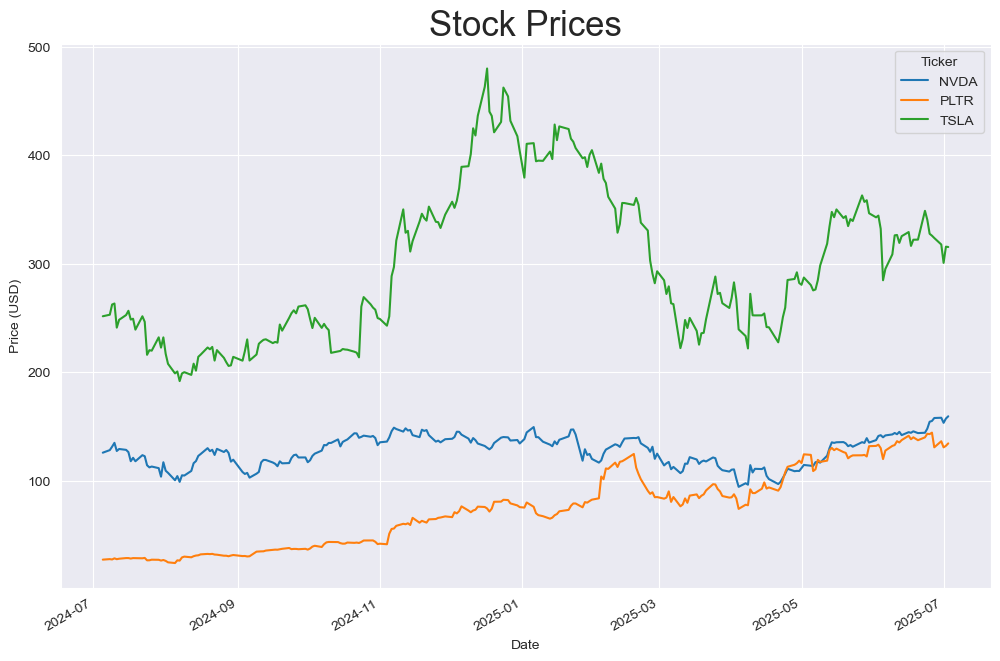

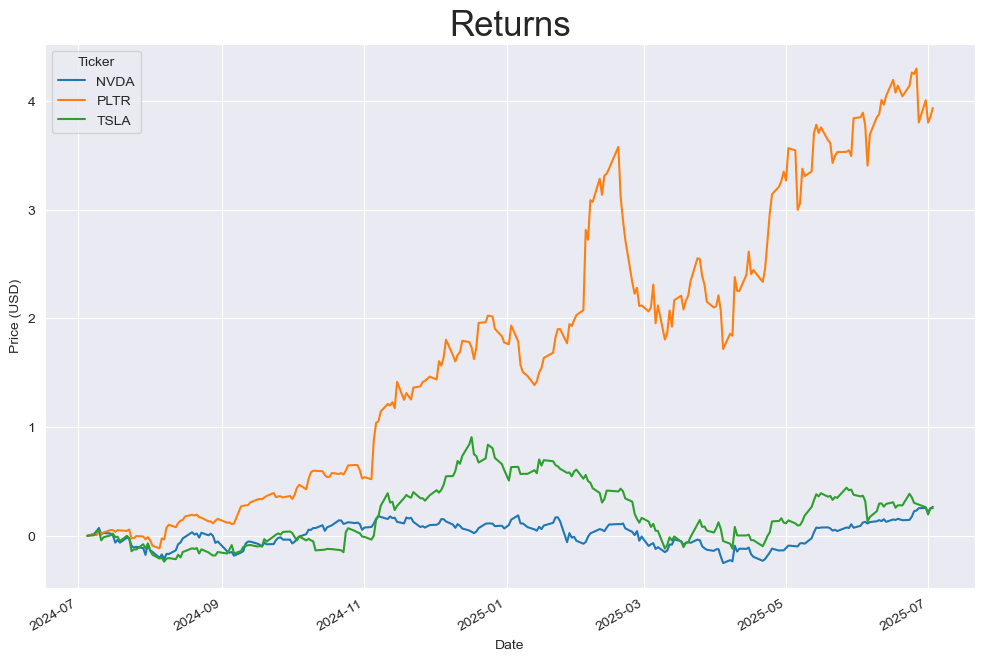

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
import decimal
import warnings
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

import yfinance as yf

tickers=['TSLA', 'PLTR', 'NVDA']
start_date = dt.datetime.today()-dt.timedelta(days = 365)
end_date = dt.datetime.today()
stock = yf.download(tickers, start = start_date, end =end_date)
stock['Close'].plot(figsize = (12,8))
plt.title(f'Stock Prices', size = 25)
plt.ylabel('Price (USD)')
plt.show()
close = stock['Close']
close.head()
close = stock['Close']
normalized_returns = close/close.iloc[0]-1 #Moves stock prices to a start of 0


# Step 2: Create MultiIndex columns for new data
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])

# Step 3: Concatenate to the original DataFrame
stock = pd.concat([stock, normalized_returns], axis =1 )
#Plot Cumlative Returns together
stock['Cumulative Return'].plot(figsize = (12,8))
plt.title(f'Returns', size = 25)
plt.ylabel('Price (USD)')
plt.show()

In [157]:
tickers=['TSLA', 'PLTR', 'NVDA']
start_date = dt.datetime.today()-dt.timedelta(days = 365)
end_date = dt.datetime.today()

stock = yf.download(tickers, start = start_date, end = end_date)
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()

stock.head()

#Create a dataframe of daily returns
#It is quite common to take the logs of daily returns to lessen computational complexity in standard deviation
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()



#Create a dictionary of standard deviations of daily return
#Normalize the standard deviation for yearly by multiplying by sqrt(#trading days in year ~ 252)
annualized_volatility = {ticker: np.std(daily_returns[ticker])*np.sqrt(252) for ticker in tickers}

annualized_volatility

[*********************100%***********************]  3 of 3 completed


{'TSLA': 0.7299982332517551,
 'PLTR': 0.7148314695629177,
 'NVDA': 0.5767530338457166}

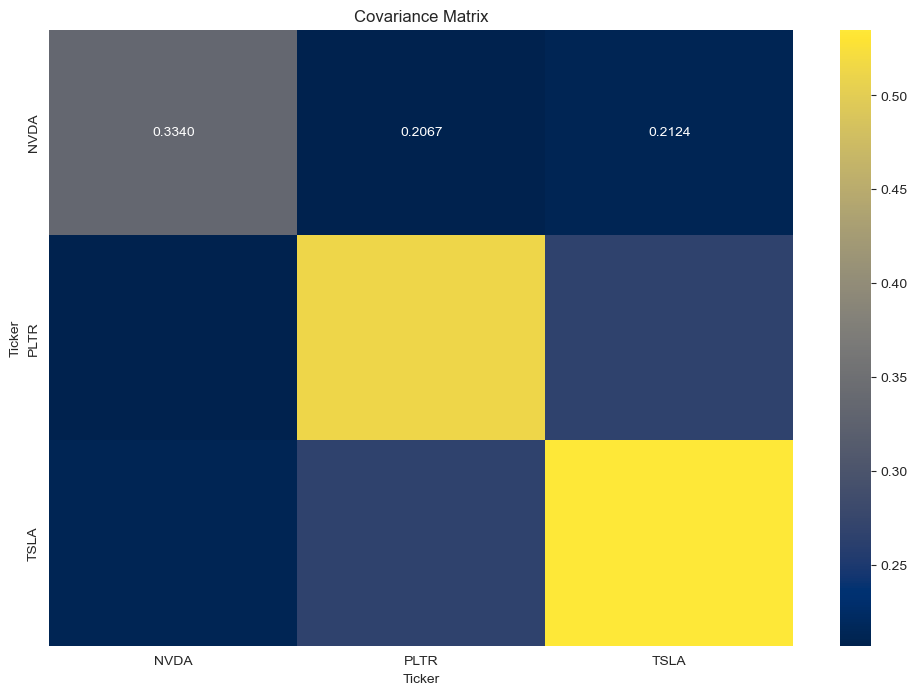

In [158]:
covariance_matrix = 252*((daily_returns).cov())
covariance_matrix
plt.figure(figsize = (12,8))
sns.heatmap(covariance_matrix, annot=True, cmap='cividis', fmt ='.4f')
plt.title('Covariance Matrix')
plt.show()

Optimal Asset Weights to maximaize return:
TSLA: Weight = 0.0100
PLTR: Weight = 0.9800
NVDA: Weight = 0.0100
This shows in a year we can gain 386.0786833164666% when optimizing for yearly return, however what is the volitility?


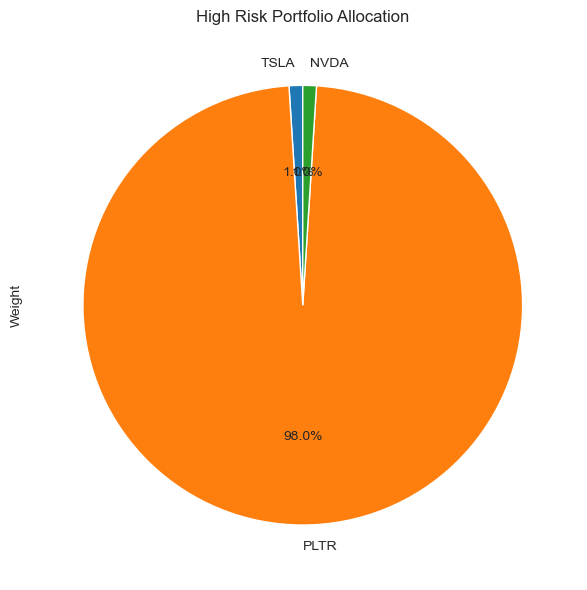

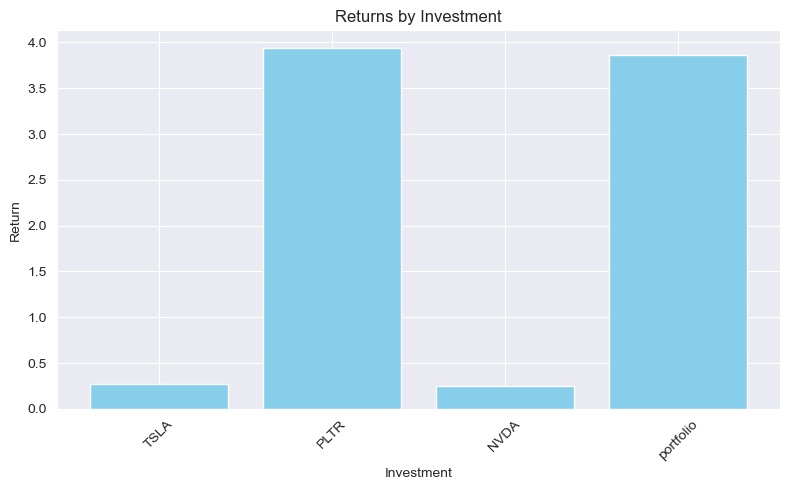

In [159]:
#Find a set of weights, equivalently portfolio investment percentages in stock_symbols, 
#which minimizes a historical portfolio's volatility subject to the following investment constraints
#Must invest at least 1% of capital into each index (changed from 10% to 1% just to make sure there is something invested in each)

#Create dictionary average/expected daily return for indexes in stock_symbols normalized for yearly return
#expected_returns = {stock: 252*np.mean(returns[stock]) for stock in stock_symbols}


# Number of assets
n_assets = len(tickers)

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets] * n_assets)

# Define weight constraints
#Sum of weights equals 1 
#Allocate at least 1% of capital into each index in stock_symbols
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-.01})

# Define the objective function to minimize portfolio variance
new_stock = stock['Close']
#returns = (new_stock.iloc[-1, 1:] / new_stock.iloc[-201, 1:]) - 1
#print(new_stock.iloc[-1]) 
#print(new_stock.iloc[0])
recent_returns = (new_stock.iloc[-1]-new_stock.iloc[0])/new_stock.iloc[0]
#print(recent_returns[1])
#print(np.dot( recent_returns, initial_weights))

def portfolio_profit(weights):
    portfolio_return = -1 * np.dot(recent_returns, weights)
    return portfolio_return

# Run the optimization to find the optimal weights
result = minimize(portfolio_profit, initial_weights, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

# Print the optimal weights and expected returns
print('Optimal Asset Weights to maximaize return:')
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")
print('This shows in a year we can gain '+ str(-1*portfolio_profit(optimal_weights)*100)+ '% when optimizing for yearly return, however what is the volitility?')

highrisk_table = pd.Series(optimal_weights, index=tickers, name='Weight')
fig, ax = plt.subplots(figsize=(14, 6))
highrisk_table.plot.pie(ax=ax, autopct='%1.1f%%', startangle=90)
ax.set_title("High Risk Portfolio Allocation")
plt.tight_layout()
plt.show()


investment = tickers+['portfolio']
values = [recent_returns[0],recent_returns[1],recent_returns[2],-1*portfolio_profit(optimal_weights)]

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(investment, values, color='skyblue')
plt.xlabel("Investment")
plt.ylabel("Return")
plt.title("Returns by Investment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [162]:
portfolio_std_dev = np.sqrt(np.dot(optimal_weights.T, np.dot(covariance_matrix, optimal_weights)))
print("The volitility of the portfolio is "+str(portfolio_std_dev))

The volitility of the portfolio is 0.7086053257376623


In [161]:
dividends_dict = {}
start_date = dt.datetime.today()-dt.timedelta(days = 365)
end_date = dt.datetime.today()
for ticker in tickers:
    
    t = yf.Ticker(ticker)
    # Get dividend history and filter by your date range
    dividends = t.dividends
    dividends.index = dividends.index.tz_localize(None)
    dividends = dividends[(dividends.index >= start_date) & (dividends.index <= end_date)]
    dividends_dict[ticker] = dividends

# Convert to DataFrame: one column per ticker
dividends_df = pd.DataFrame(dividends_dict)

# Optional: fill NaNs with 0 (where dividends weren’t paid)
dividends_df = dividends_df.fillna(0)

# View a sample
print(dividends_df.head())
print(dividends_df.tail())
dividend_yields = []

for ticker in tickers:
    t = yf.Ticker(ticker)
    
    # Get dividend history and remove timezone
    div = t.dividends
    div.index = div.index.tz_localize(None)
    
    # Filter last 5 years
    div_5y = div[(div.index >= start_date) & (div.index <= end_date)]
    total_div_5y = div_5y.sum()
    
    # Average annual dividends over 5 years
    avg_annual_div = total_div_5y / 5
    
    # Get most recent price
    price = t.history(period='1d')['Close'].iloc[-1]
    
    # Compute 5-year average annual dividend yield
    yield_pct = avg_annual_div / price if price > 0 else 0
    dividend_yields.append(yield_pct)

# Compute weighted portfolio dividend yield
portfolio_div_yield = sum(w * y for w, y in zip(optimal_weights, dividend_yields))

# Show results
for ticker, w, y in zip(tickers, optimal_weights, dividend_yields):
    print(f"{ticker:<6} | 5-Yr Avg Yield: {y:.2%} | Weighted: {(w * y):.8%}")
print("\n 5-Year Avg Annual Portfolio Dividend Yield:", f"{decimal.Decimal(portfolio_div_yield):.8%}")
print("\n the dividend is extremely small.")

            TSLA  PLTR  NVDA
Date                        
2024-09-12   0.0   0.0  0.01
2024-12-05   0.0   0.0  0.01
2025-03-12   0.0   0.0  0.01
2025-06-11   0.0   0.0  0.01
            TSLA  PLTR  NVDA
Date                        
2024-09-12   0.0   0.0  0.01
2024-12-05   0.0   0.0  0.01
2025-03-12   0.0   0.0  0.01
2025-06-11   0.0   0.0  0.01
TSLA   | 5-Yr Avg Yield: 0.00% | Weighted: 0.00000000%
PLTR   | 5-Yr Avg Yield: 0.00% | Weighted: 0.00000000%
NVDA   | 5-Yr Avg Yield: 0.01% | Weighted: 0.00005020%

 5-Year Avg Annual Portfolio Dividend Yield: 0.00005020%

 the dividend is extremely small.


## Conclusion

These results show that this portfolio had the potential of getting more than quadrupuled but the volitility is 70% which is extremley high. It's worth noting that two of these companies are not dividend paying and the otehr pays ver small amount so the portfolio basically pays no dividend.